In [1]:
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tqdm import tqdm
from matplotlib import pyplot as plt


from src.visualization import set_themes
from src.preprocessing.data_loader import load_data

set_themes()
tf.config.list_logical_devices()

failed to send, dropping 5 traces to intake at http://localhost:8126/v0.5/traces after 3 retries
2026-01-05 11:04:54.635273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hafidh_rendyanto/documents/peppermint-matrix/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2026-01-05 11:04:58.139875: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1767611098.141547 2799360 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19272 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Data Loading

In [2]:
train_user_interaction = load_data("dataset/yelp2018/train.txt")
train_user_interaction

,user_id,item_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1237254,31667,22984
1237255,31667,12943
1237256,31667,29149
1237257,31667,4927


In [3]:
user_count, item_count = train_user_interaction["user_id"].nunique(), train_user_interaction["item_id"].nunique()
user_count, item_count

(31668, 38048)

In [4]:
item_set = train_user_interaction["item_id"].unique()
user_set = train_user_interaction["user_id"].unique()

In [5]:
user_items = train_user_interaction.groupby("user_id")["item_id"].apply(set).to_dict()
item_users = train_user_interaction.groupby("item_id")["user_id"].apply(set).to_dict()

In [6]:
sparse_interaction_matrix = tf.sparse.SparseTensor(
    indices=train_user_interaction[["user_id", "item_id"]].values,
    values=tf.ones(shape=(len(train_user_interaction),), dtype=tf.float32),
    dense_shape=(user_count, item_count)
)
sparse_interaction_matrix

SparseTensor(indices=tf.Tensor(
[[    0     0]
 [    0     1]
 [    0     2]
 ...
 [31667 29149]
 [31667  4927]
 [31667 31751]], shape=(1237259, 2), dtype=int64), values=tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(1237259,), dtype=float32), dense_shape=tf.Tensor([31668 38048], shape=(2,), dtype=int64))

# Model Definition

In [7]:
user_embedding_layer = keras.layers.Embedding(user_count, 8)
item_embedding_layer = keras.layers.Embedding(item_count, 8)

user_embedding_layer.build((None,))
item_embedding_layer.build((None,))

# Model Training

In [9]:
NEPOCH = 10
BATCH_SIZE = 16384
PROPAGATION_COUNT = 2 # how many graph propagation layers
LEARNING_RATE = 0.01

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_epoch_history = []
loss_batch_history = []
for epoch in range(NEPOCH):
    batch_loss = []
    with tqdm(total=len(train_user_interaction)) as pbar:
        for start_idx in range(0, len(train_user_interaction), BATCH_SIZE):
            user_id = train_user_interaction["user_id"][start_idx:(start_idx + BATCH_SIZE)]
            item_id = train_user_interaction["item_id"][start_idx:(start_idx + BATCH_SIZE)]

            # random negative sample
            random_negative = np.random.choice(item_set, size=len(user_id))
            for i, uid in enumerate(user_id):
                while random_negative[i] in user_items[uid]:
                    random_negative[i] = np.random.choice(item_set)
            
            user_id = tf.constant(user_id)
            item_id = tf.constant(item_id)
            random_negative = tf.constant(random_negative)

            # forward propagation
            with tf.GradientTape() as tape:
                # initialize graph propagation
                propagated_user_embedding_populations = [user_embedding_layer.variables[0]]
                propagated_item_embedding_populations = [item_embedding_layer.variables[0]] 

                for l in range(PROPAGATION_COUNT):
                    # user propagation
                    current_user_embedding_population = tf.sparse.sparse_dense_matmul(sparse_interaction_matrix, propagated_item_embedding_populations[-1]) / tf.sparse.reduce_sum(sparse_interaction_matrix, axis=-1)[:, tf.newaxis]
                    # item propagation
                    current_item_embedding_population = tf.sparse.sparse_dense_matmul(tf.sparse.transpose(sparse_interaction_matrix), propagated_user_embedding_populations[-1]) / tf.sparse.reduce_sum(tf.sparse.transpose(sparse_interaction_matrix), axis=-1)[:, tf.newaxis]
                    
                    propagated_user_embedding_populations.append(current_user_embedding_population)
                    propagated_item_embedding_populations.append(current_item_embedding_population)

                user_embeddings = []
                item_embeddings = []
                negative_embeddings = []
                for l in range(PROPAGATION_COUNT + 1):
                    user_embeddings.append(tf.nn.embedding_lookup(propagated_user_embedding_populations[l], user_id))
                    item_embeddings.append(tf.nn.embedding_lookup(propagated_item_embedding_populations[l], item_id))
                    negative_embeddings.append(tf.nn.embedding_lookup(propagated_item_embedding_populations[l], random_negative))

                user_embeddings = tf.reduce_mean(user_embeddings, axis=0)
                item_embeddings = tf.reduce_mean(item_embeddings, axis=0)
                negative_embeddings = tf.reduce_mean(negative_embeddings, axis=0)

                positive_prediction = tf.reduce_sum(user_embeddings * item_embeddings, axis=-1)
                negative_prediction = tf.reduce_sum(user_embeddings * negative_embeddings, axis=-1)

                loss_value = tf.reduce_mean(-tf.math.log(tf.sigmoid(positive_prediction - negative_prediction)))

            # calculate gradient
            user_gradient, item_gradient = tape.gradient(loss_value, user_embedding_layer.trainable_variables + item_embedding_layer.trainable_variables)

            # back propagation
            optimizer.apply_gradients(zip([user_gradient, item_gradient], user_embedding_layer.trainable_variables + item_embedding_layer.trainable_variables))

            loss_batch_history.append(float(loss_value))
            batch_loss.append(float(loss_value))

            pbar.update(len(item_id))
            pbar.set_postfix({"loss": float(loss_value)})
            pbar.set_description(f"[{epoch+1}/{NEPOCH}]")
    
    loss_epoch_history.append(float(tf.reduce_mean(batch_loss)))

[10/10]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1237259/1237259 [00:30<00:00, 40319.71it/s, loss=0.11]


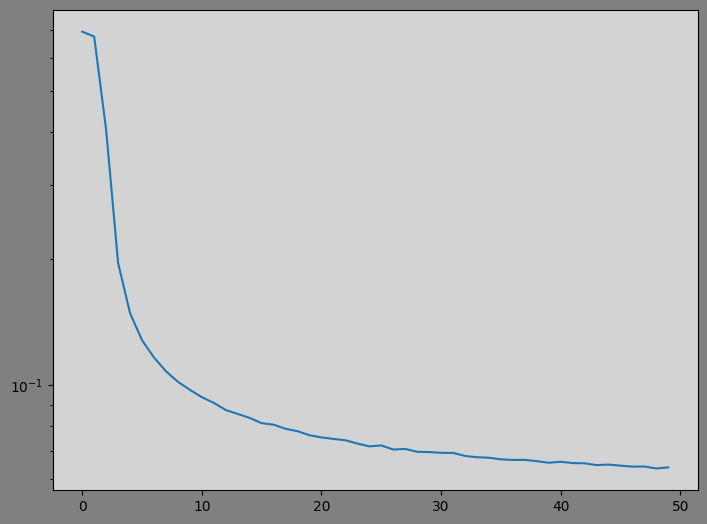

In [13]:
plt.plot(loss_epoch_history)
plt.yscale("log")
plt.show()

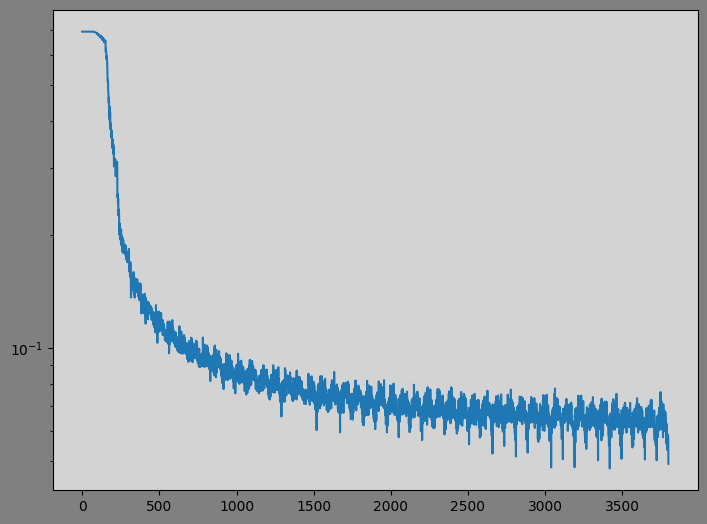

In [14]:
plt.plot(loss_batch_history)
plt.yscale("log")
plt.show()